In [1]:
#NOTE:  This must be the first call in order to work properly!
from deoldify import device
from deoldify.device_id import DeviceId
#choices:  CPU, GPU0...GPU7
device.set(device=DeviceId.GPU0)

<DeviceId.GPU0: 0>

In [2]:
from fastai.core import *
from fastai.vision import *
from matplotlib.axes import Axes
from deoldify.filters import IFilter, MasterFilter, ColorizerFilter
from deoldify.generators import gen_inference_deep, gen_inference_wide
from PIL import Image
import requests
from io import BytesIO
from IPython import display as ipythondisplay
from IPython.display import HTML
import cv2
from IPython.display import Image as ipythonimage

In [3]:
def get_watermarked(pil_image: Image) -> Image:
    try:
        image = cv2.cvtColor(np.array(pil_image), cv2.COLOR_RGB2BGR)
        (h, w) = image.shape[:2]
        image = np.dstack([image, np.ones((h, w), dtype="uint8") * 255])
        pct = 0.05
        full_watermark = cv2.imread(
            './resource_images/watermark.png', cv2.IMREAD_UNCHANGED
        )
        (fwH, fwW) = full_watermark.shape[:2]
        wH = int(pct * h)
        wW = int((pct * h / fwH) * fwW)
        watermark = cv2.resize(full_watermark, (wH, wW), interpolation=cv2.INTER_AREA)
        overlay = np.zeros((h, w, 4), dtype="uint8")
        (wH, wW) = watermark.shape[:2]
        overlay[h - wH - 10 : h - 10, 10 : 10 + wW] = watermark
        # blend the two images together using transparent overlays
        output = image.copy()
        cv2.addWeighted(overlay, 0.5, output, 1.0, 0, output)
        rgb_image = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
        final_image = Image.fromarray(rgb_image)
        return final_image
    except:
        # Don't want this to crash everything, so let's just not watermark the image for now.
        return pil_image


class ModelImageVisualizer:
    def __init__(self, filter: IFilter, results_dir: str = None):
        self.filter = filter
        self.results_dir = None if results_dir is None else Path(results_dir)
        self.results_dir.mkdir(parents=True, exist_ok=True)

    def _clean_mem(self):
        torch.cuda.empty_cache()
        # gc.collect()

    def _open_pil_image(self, path: Path) -> Image:
        return PIL.Image.open(path).convert('RGB')

    def _get_image_from_url(self, url: str) -> Image:
        response = requests.get(url, timeout=30, headers={'user-agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/62.0.3202.94 Safari/537.36'})
        img = PIL.Image.open(BytesIO(response.content)).convert('RGB')
        return img

    def plot_transformed_image_from_url(
        self,
        url: str,
        path: str = 'test_images/image.png',
        results_dir:Path = None,
        figsize: Tuple[int, int] = (20, 20),
        render_factor: int = None,
        
        display_render_factor: bool = False,
        compare: bool = False,
        post_process: bool = True,
        watermarked: bool = True,
    ) -> Path:
        img = self._get_image_from_url(url)
        img.save(path)
        return self.plot_transformed_image(
            path=path,
            results_dir=results_dir,
            figsize=figsize,
            render_factor=render_factor,
            display_render_factor=display_render_factor,
            compare=compare,
            post_process = post_process,
            watermarked=watermarked,
        )

    def plot_transformed_image(
        self,
        path: str,
        results_dir:Path = None,
        figsize: Tuple[int, int] = (20, 20),
        render_factor: int = None,
        display_render_factor: bool = False,
        compare: bool = False,
        post_process: bool = True,
        watermarked: bool = True,
    ) -> Path:
        path = Path(path)
        if results_dir is None:
            results_dir = Path(self.results_dir)
        result = self.get_transformed_image(
            path, render_factor, post_process=post_process,watermarked=watermarked
        )
        orig = self._open_pil_image(path)
        if compare:
            self._plot_comparison(
                figsize, render_factor, display_render_factor, orig, result
            )
        else:
            self._plot_solo(figsize, render_factor, display_render_factor, result)

        orig.close()
        result_path = self._save_result_image(path, result, results_dir=results_dir)
        result.close()
        return result_path

    def _plot_comparison(
        self,
        figsize: Tuple[int, int],
        render_factor: int,
        display_render_factor: bool,
        orig: Image,
        result: Image,
    ):
        fig, axes = plt.subplots(1, 2, figsize=figsize)
        self._plot_image(
            orig,
            axes=axes[0],
            figsize=figsize,
            render_factor=render_factor,
            display_render_factor=False,
        )
        self._plot_image(
            result,
            axes=axes[1],
            figsize=figsize,
            render_factor=render_factor,
            display_render_factor=display_render_factor,
        )

    def _plot_solo(
        self,
        figsize: Tuple[int, int],
        render_factor: int,
        display_render_factor: bool,
        result: Image,
    ):
        fig, axes = plt.subplots(1, 1, figsize=figsize)
        self._plot_image(
            result,
            axes=axes,
            figsize=figsize,
            render_factor=render_factor,
            display_render_factor=display_render_factor,
        )

    def _save_result_image(self, source_path: Path, image: Image, results_dir = None) -> Path:
        if results_dir is None:
            results_dir = Path(self.results_dir)
        result_path = results_dir / source_path.name
        image.save(result_path)
        return result_path

    def get_transformed_image(
        self, path: Path, render_factor: int = None, post_process: bool = True,
        watermarked: bool = True,
    ) -> Image:
        self._clean_mem()
        orig_image = self._open_pil_image(path)
        filtered_image = self.filter.filter(
            orig_image, orig_image, render_factor=render_factor,post_process=post_process
        )

        if watermarked:
            return get_watermarked(filtered_image)

        return filtered_image

    def _plot_image(
        self,
        image: Image,
        render_factor: int,
        axes: Axes = None,
        figsize=(20, 20),
        display_render_factor = False,
    ):
        if axes is None:
            _, axes = plt.subplots(figsize=figsize)
        axes.imshow(np.asarray(image) / 255)
        axes.axis('off')
        if render_factor is not None and display_render_factor:
            plt.text(
                10,
                10,
                'render_factor: ' + str(render_factor),
                color='white',
                backgroundcolor='black',
            )

    def _get_num_rows_columns(self, num_images: int, max_columns: int) -> Tuple[int, int]:
        columns = min(num_images, max_columns)
        rows = num_images // columns
        rows = rows if rows * columns == num_images else rows + 1
        return rows, columns

In [10]:
def get_image_colorizer(
    root_folder: Path = Path('/home/konstantin/Projects/Diploma/DeOldify/'), render_factor: int = 35, artistic: bool = True
) -> ModelImageVisualizer:
    if artistic:
        return get_artistic_image_colorizer(root_folder=root_folder, render_factor=render_factor)


def get_artistic_image_colorizer(
    root_folder: Path = Path('/home/konstantin/Projects/Diploma/DeOldify/'),
    weights_name: str = 'ColorizeArtistic_gen',
    results_dir='result_images',
    render_factor: int = 25
) -> ModelImageVisualizer:
    learn = gen_inference_deep(root_folder=root_folder, weights_name=weights_name)
    filtr = MasterFilter([ColorizerFilter(learn=learn)], render_factor=render_factor)
    vis = ModelImageVisualizer(filtr, results_dir=results_dir)
    return vis

In [11]:
def get_watermarked(pil_image: Image) -> Image:
    try:
        image = cv2.cvtColor(np.array(pil_image), cv2.COLOR_RGB2BGR)
        (h, w) = image.shape[:2]
        image = np.dstack([image, np.ones((h, w), dtype="uint8") * 255])
        pct = 0.05
        full_watermark = cv2.imread(
            './resource_images/watermark.png', cv2.IMREAD_UNCHANGED
        )
        (fwH, fwW) = full_watermark.shape[:2]
        wH = int(pct * h)
        wW = int((pct * h / fwH) * fwW)
        watermark = cv2.resize(full_watermark, (wH, wW), interpolation=cv2.INTER_AREA)
        overlay = np.zeros((h, w, 4), dtype="uint8")
        (wH, wW) = watermark.shape[:2]
        overlay[h - wH - 10 : h - 10, 10 : 10 + wW] = watermark
        # blend the two images together using transparent overlays
        output = image.copy()
        cv2.addWeighted(overlay, 0.5, output, 1.0, 0, output)
        rgb_image = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
        final_image = Image.fromarray(rgb_image)
        return final_image
    except:
        # Don't want this to crash everything, so let's just not watermark the image for now.
        return pil_image

In [12]:
colorizer = get_image_colorizer(artistic=True)

In [13]:
#NOTE:  Max is 45 with 11GB video cards. 35 is a good default
render_factor=25
#NOTE:  Make source_url None to just read from file at ./video/source/[file_name] directly without modification
source_url= None
source_path = '/home/konstantin/Загрузки/chb.jpg'
result_path = '/home/konstantin/Загрузки/res.jpg'

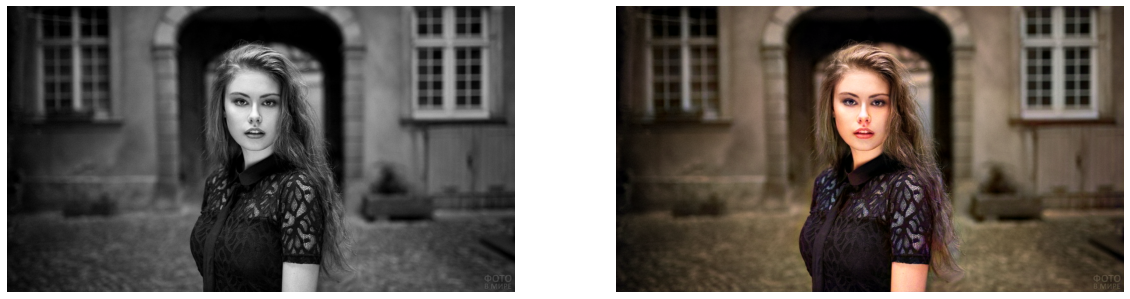

In [14]:
if source_url is not None:
    result_path = colorizer.plot_transformed_image_from_url(url=None, path=source_path, render_factor=render_factor, compare=True)
else:
    result_path = colorizer.plot_transformed_image(path=source_path, render_factor=render_factor, compare=True)